In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [61]:
df = pd.read_csv('customers_data.csv').drop('Unnamed: 0', 1).dropna()
df.head()

,purch_amt,gender,card_on_file,age,days_since_last_purch,loyalty
0,19.58,male,no,31.0,35.0,False
1,65.16,male,yes,23.0,61.0,False
2,40.60,female,no,36.0,49.0,False
3,38.01,male,yes,47.0,57.0,False
4,22.32,female,yes,5.0,39.0,False


In [62]:
# some variables are missing becasue they are not numerical values
df.describe()

,purch_amt,age,days_since_last_purch
count,120000.000000,120000.000000,120000.000000
mean,44.036234,25.803008,56.605908
std,20.473148,10.153072,16.422187
min,-43.950000,-22.000000,-9.000000
25%,30.210000,19.000000,45.000000
50%,43.970000,26.000000,57.000000
75%,57.830000,33.000000,68.000000
max,142.200000,71.000000,125.000000


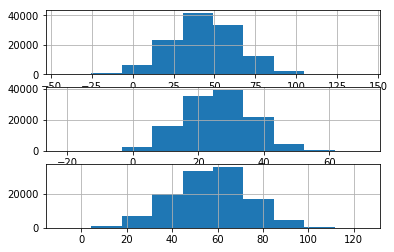

In [63]:
#Quike look at the distribution of the variables
f, (ax1, ax2, ax3) = plt.subplots(3)
df.purch_amt.hist(ax=ax1)
df.age.hist(ax=ax2)
df.days_since_last_purch.hist(ax=ax3)

False    100000
True      20000
Name: loyalty, dtype: int64


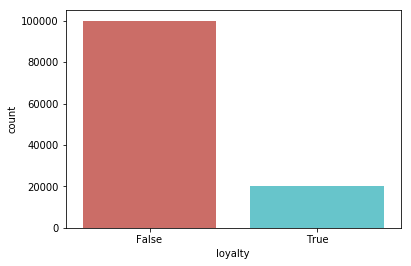

In [64]:
#The data contains unequal number of points for two outcomes
#This could lead to bias so we need to under or over sample it
import seaborn as sns
print(df['loyalty'].value_counts())
sns.countplot(x='loyalty', data=df, palette='hls')

In [65]:
#dummy variables for catigoriacal and non-numerical variables,
#models only accepts numbers
#don't mess with orignial dataframe therefore df2
df2 = pd.get_dummies(df)
df2.head()

,purch_amt,age,days_since_last_purch,loyalty,gender_female,gender_male,card_on_file_no,card_on_file_yes
0,19.58,31.0,35.0,False,0,1,1,0
1,65.16,23.0,61.0,False,0,1,0,1
2,40.60,36.0,49.0,False,1,0,1,0
3,38.01,47.0,57.0,False,0,1,0,1
4,22.32,5.0,39.0,False,1,0,0,1


In [66]:
#split the data in to test and train and over and under sample on the train data set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df2, test_size=0.2)
datanumb = train['loyalty'].value_counts()
datanumb

False    80094
True     15906
Name: loyalty, dtype: int64

In [67]:
#In the test data set there are far more 'False' than are 'True'
test['loyalty'].value_counts()

False    19906
True      4094
Name: loyalty, dtype: int64

In [68]:
#Oversampling
train_oversample = train[train['loyalty'] == True].sample(n=datanumb[0], replace=True)
train_false_value = train[train['loyalty'] == False]
#randomize the samples
train_oversample = pd.concat([train_oversample, train_false_value], ignore_index=True).sample(frac=1.0)
print(train_oversample['loyalty'].value_counts())
train_oversample.head()

True     80094
False    80094
Name: loyalty, dtype: int64


,purch_amt,age,days_since_last_purch,loyalty,gender_female,gender_male,card_on_file_no,card_on_file_yes
145069,71.48,12.0,89.0,False,0,1,0,1
2167,63.36,12.0,8.0,True,0,1,0,1
60798,41.75,32.0,47.0,True,0,1,0,1
18770,68.65,45.0,38.0,True,1,0,1,0
143948,68.51,14.0,65.0,False,1,0,0,1


In [69]:
#Optimization using gridsearch on the over sampled data
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

classsifier = LogisticRegression()

gridparam = {'C': [0.1, 1],
             'penalty': ['l2'],
             'solver': ['newton-cg', 'lbfgs'],
             'max_iter': [1000],
            'n_jobs': [4]
            }

logit_model_over = GridSearchCV(classsifier, param_grid=gridparam, cv=5)
logit_model_over.fit(train_oversample.drop('loyalty', 1), train_oversample['loyalty'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs'], 'max_iter': [1000], 'n_jobs': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [70]:
from sklearn.model_selection import cross_val_score
clf = logit_model_over.best_estimator_
cross_val_score(clf, test.drop('loyalty', 1), test['loyalty'], cv=5)

array([0.86794418, 0.871875  , 0.86083333, 0.86416667, 0.86413836])

In [84]:
clf.score(train_oversample.drop('loyalty', 1), train_oversample['loyalty'])

0.7952343496391739

In [71]:
from sklearn.metrics import classification_report
y_over_pred = clf.predict(test.drop('loyalty', 1))
print(classification_report(test['loyalty'], y_over_pred, target_names=['True', 'False']))
pd.crosstab(test['loyalty'], y_over_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

        True       0.95      0.78      0.86     19906
       False       0.44      0.81      0.57      4094

   micro avg       0.79      0.79      0.79     24000
   macro avg       0.69      0.80      0.71     24000
weighted avg       0.86      0.79      0.81     24000



Predicted,False,True,All
True,,,
False,15612,4294,19906
True,782,3312,4094
All,16394,7606,24000


In [77]:
#under sample
train_undersample = train[train['loyalty'] == False].sample(n=datanumb[1], replace=False)
train_True_value = train[train['loyalty'] == True]
#randomize the samples
train_undersample = pd.concat([train_undersample, train_True_value], ignore_index=True).sample(frac=1.0)
print(train_undersample['loyalty'].value_counts())
train_undersample.head()

True     15906
False    15906
Name: loyalty, dtype: int64


,purch_amt,age,days_since_last_purch,loyalty,gender_female,gender_male,card_on_file_no,card_on_file_yes
9878,57.09,14.0,52.0,False,1,0,0,1
13040,52.82,21.0,79.0,False,0,1,0,1
18467,41.10,28.0,32.0,True,0,1,0,1
25340,4.17,19.0,56.0,True,1,0,1,0
5891,41.53,27.0,69.0,False,0,1,0,1


In [78]:
#Optimization using gridsearch on the under sampled data
logit_model_under = GridSearchCV(classsifier, param_grid=gridparam, cv=5)
logit_model_under.fit(train_undersample.drop('loyalty', 1), train_undersample['loyalty'])

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'C': [0.1, 1], 'penalty': ['l2'], 'solver': ['newton-cg', 'lbfgs'], 'max_iter': [1000], 'n_jobs': [4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [79]:
clf2 = logit_model_over.best_estimator_
cross_val_score(clf2, test.drop('loyalty', 1), test['loyalty'], cv=5)

array([0.86794418, 0.871875  , 0.86083333, 0.86416667, 0.86413836])

In [85]:
clf2.score(train_undersample.drop('loyalty', 1), train_undersample['loyalty'])

0.7950144599522193

<p style="font-family:Helvetica Neue;font-size:20px">The model trained with both under and over-sampled training dataset did not produce overfitting problem but the models predicted 'False' and 'True' of the test dataset with exactly the same precision. As you can see below.</p>

In [80]:
y_under_pred = clf2.predict(test.drop('loyalty', 1))
print(classification_report(test['loyalty'], y_under_pred, target_names=['True', 'False']))
pd.crosstab(test['loyalty'], y_under_pred, rownames=['True'], colnames=['Predicted'], margins=True)

              precision    recall  f1-score   support

        True       0.95      0.78      0.86     19906
       False       0.44      0.81      0.57      4094

   micro avg       0.79      0.79      0.79     24000
   macro avg       0.69      0.80      0.71     24000
weighted avg       0.86      0.79      0.81     24000



Predicted,False,True,All
True,,,
False,15612,4294,19906
True,782,3312,4094
All,16394,7606,24000
